# SVM in Image Classification
## Dan Zhou(dzhou2)
During the class, we have learnt some theory about support vector machine. It could be used to classify data. And for HW3, we have used support machine to classify text. In this tutorial, I would like to introduce how we could use support vector machine to classfify pictures.

Before we start, since we will use openCV function in this tutorial, if you haven't install that package in your computer you should run:
 
   ```python
   >>>pip install opencv-python
   ```
    
in the terminal(for Mac), then you could use openCV functions.

After installation, Let's get started!

In [7]:
import scipy
import csv as csv
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as sk
from numpy import array
import cv2
import os
import skimage as ski
import random
from PIL import Image 
from PIL import ImageFilter
from sklearn.svm import LinearSVC, SVC
import re
from skimage.feature import hog,local_binary_pattern
from skimage import data, exposure
import matplotlib.pyplot as plt
from collections import Iterable

The dataSet we use for this tutorial is the famous Dogs and Cats dataset from kaggle competitation. There are 25000 pictures about cats and dogs,half dogs and half cats in training set and 10000 pictures in test set

Due the time and constrain, I would use only 5000 images from training dataset.The pictures in training set are disordered. Then we could ues first 4000 as training data and remaining as test set

The whole dataset can be downloaded from:

https://www.kaggle.com/c/dogs-vs-cats/data

untar it in the same folder as this notebook

To verify the accuracy of our algorithm, we have to assign correct label for every picture in training data or test data. If the picture is dog, assign 1, otherwise assign 0.

In [8]:
TRAIN_DIR = 'train/'
input_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for training images
training_images = input_images[0:4000]
test_images = input_images[4000:5000];
print(training_images[0:10])
print(len(test_images))

 # cat:0 dog:1
pic_size = 64, 128

def create_label(input):
    label = []
    
    for i in input:
        if 'dog' in i:
            label.append(1)
        else:
            label.append(0)
    return label

['train/dog.8011.jpg', 'train/cat.5077.jpg', 'train/dog.7322.jpg', 'train/cat.2718.jpg', 'train/cat.10151.jpg', 'train/cat.3406.jpg', 'train/dog.1753.jpg', 'train/cat.4369.jpg', 'train/cat.7660.jpg', 'train/dog.5535.jpg']
1000


Another important aspect of svm is feature. In the picture recognition, we apply Histograms of Oriented Gradients (HOG) method to attract features from one picture.

We couldn't apply HOG to picture directly, because HOG requires a fix number of pixels and cells. Therefore, we have to resize the picture to 64*128 first. Also, we transfer the pictures into grey pictures, this will decrease the size of features.

To learn more about HOG, you could go through the Wikipedia Page: https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients

Here we try two build in function: HOGDescriptor and skimage.feature. These two method use the same algorithm with different paramerter represenations.Here, I would like to introduce HOGDescriptor in detail.

winSize is the size of input picture, here we use 64*128

blocksize is the number of cells in one block

blockstride: how mamy cells move for the next block

cellsize: number of pixel in one cell

For other parameters, we would use the default values

The following code shows what the images look like after extract features using HOG

From the result, we can see that HOG is sensitive to boarder in the images


/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


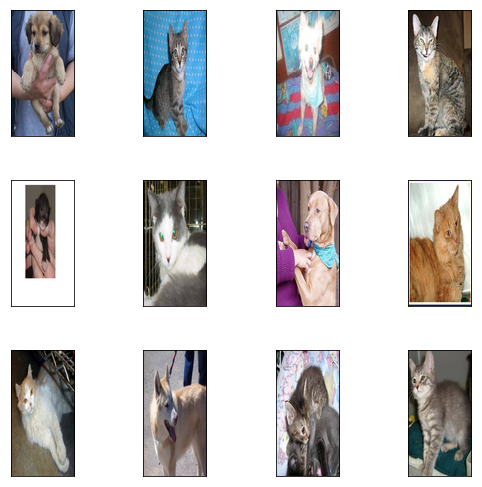

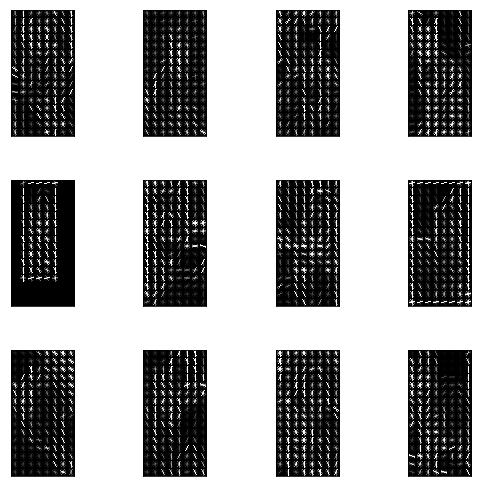

In [9]:
def plot_gallery(images, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
       
        img = Image.open(images[i])
        img = img.resize(pic_size, Image.ANTIALIAS)
        plt.imshow(img)
        plt.xticks(())
        plt.yticks(())
plot_gallery(training_images[0:12], 64, 128)

def getHOG(images, n_row=3, n_col=4):
    hog_list = []
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        img_hog = Image.open(images[i])
        img_hog = img_hog.convert("L")
        img_hog = img_hog.resize(pic_size, Image.ANTIALIAS)
        img_array_h = np.array(img_hog)
        _, hog_img =  hog(img_array_h, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2,2), visualise=True)
        hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))
        plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
        hog_list.append(hog_image_rescaled)
    return hog_list


hog_image_list = getHOG(training_images[0:12])
plt.show()

Then we use the function to get features from all traning images and test images.

Here we also implement another features extraction function called local_binary_pattern(LBP), we want to compare the result for different extraction function.

LBP is more suitable for texture classification because it calculate 

For HOG features, linear SVM has a better performace compared to rbf and poly SVMs.

In [10]:
#generate feature matrix for a series of input pictures
def getFeature(input):
    feature = []
    feature_lbp = []

    for i in input:
        #pre-word before sending to HOG
        img = Image.open(i);
        img = img.convert("L")
        img = img.resize(pic_size, Image.ANTIALIAS)
        lbp = local_binary_pattern(img, n_points, radius,METHOD)
        img_array = np.array(img)
        fd = hog_cv.compute(img_array)
        flat = lambda t: [x for sub in t for x in flat(sub)] if isinstance(t, Iterable) else [t]
        feature.append(flat(fd))
        feature_lbp.append(lbp.flatten())

    return feature, feature_lbp

# def getLBPFeature(input):
#     feature = []
#     for i in input:
#         img = Image.open(i);
#         img = img.convert("L")
#         img = img.resize(pic_size, Image.ANTIALIAS)
#         lbp = local_binary_pattern(img, n_points, radius,METHOD)
#         feature.append(lbp.flatten())
#     return feature
        

#parameter for HOGDesctiptor function
winSize = (64,128)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
signedGradients = True
hog_cv = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels,signedGradients)


METHOD = 'uniform'
radius = 8
n_points =  16

def class_svm(X,Y,kernel):
    clf = SVC(kernel = kernel)
    clf.fit(X, Y)
    return clf



Then we want the verify the performance of SVM+HOG and SVM+LBP in cats and dogs classification

Here, we will see the accurancy on training set, which means if it could classfify an image correctly after learn it once. And also see the accurancy on test set, which means how will the algorithm classify an image it hasn't seen before.

With a small amount of training data and test data, we could see that SVM +HOG and SVM+LBP both have good performance on training data, and HOG performance on test data is around 0.65, which is not very good but beat the baseline 0.5.

For larger dataset, the accurancy of LBP on test set will decrease a lot,even lower than the baseline. This is because the features extracted by LBP is more uesful for uniform images such as texture classification.
 

In [11]:
train_label = create_label(training_images)
feature, featureLBP = getFeature(training_images)
# featureLBP, = getLBPFeature(training_images)

test_feature1, test_feature1_LBP = getFeature(training_images)
# test_feature1_LBP = getLBPFeature(training_images)
test_true_label1 = create_label(training_images)


test_feature2,test_feature2_LBP = getFeature(test_images)
# test_feature2_LBP = getLBPFeature(test_images)
test_true_label2 = create_label(test_images)


train_svm = class_svm(feature, train_label, 'linear')
y = train_svm.predict(test_feature1)
diff = test_true_label1 - y
diff = np.array(diff)
n =list(diff.nonzero())
acc = (1-len(n[0])/len(y))
print('train HOG:',acc)
    
y = train_svm.predict(test_feature2)
diff = test_true_label2 - y
diff = np.array(diff)
n =list(diff.nonzero())
acc = (1-len(n[0])/len(y))
print('test HOG:',acc)

train_svm = class_svm(featureLBP, train_label, 'linear')
y = train_svm.predict(test_feature1_LBP)
diff = test_true_label1 - y
diff = np.array(diff)
n =list(diff.nonzero())
acc = (1-len(n[0])/len(y))
print('train LBP:',acc)
    
y = train_svm.predict(test_feature2_LBP)
diff = test_true_label2 - y
diff = np.array(diff)
n =list(diff.nonzero())
acc = (1-len(n[0])/len(y))
print('test LBP:',acc)
    



train HOG: 0.9672499999999999
test HOG: 0.661
train LBP: 1.0
test LBP: 0.5800000000000001


#### 

### Summary
The process to classify images:

1. Label each input as positive or negative
2. Extract features from images with approciate algorithm, such that HOG is suitable for object detection, LBP is suitable for texture classification. And there are many other algorithm such as SURF and SIFT
3. Using different machine learning algorithm to training data. In this tutorial, we try SVM. However, it has been proof that CNN and Linear Regression may have better performance on this dataset

This tutorial is a very general instruction, there are many aspect of this problem can be improved a lot. With better algorithm, the accuracy of test dataset can be 99.6%

You can learn more about this classfication dataset at:
https://www.kaggle.com/c/dogs-vs-cats